# Análise WIN para a estratégia de abertura

## Importando os dados

In [1]:
import pandas as pd

df_mini_indice = pd.read_csv('WIN$N_M1.csv', sep='\t')
df_mini_indice

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2020.10.15,11:49:00,98565,98575,98530,98575,2373,9001,5
1,2020.10.15,11:50:00,98570,98625,98570,98600,5483,19111,5
2,2020.10.15,11:51:00,98595,98600,98535,98580,4572,17663,5
3,2020.10.15,11:52:00,98575,98620,98535,98615,3536,13143,5
4,2020.10.15,11:53:00,98620,98625,98575,98610,3729,13702,5
...,...,...,...,...,...,...,...,...,...
282758,2022.12.06,17:56:00,110540,110545,110450,110495,7707,27987,5
282759,2022.12.06,17:57:00,110500,110520,110430,110460,4475,16087,5
282760,2022.12.06,17:58:00,110465,110510,110390,110450,7481,25731,5
282761,2022.12.06,17:59:00,110455,110500,110425,110465,4074,10868,5


## Analisando os dados

### Verificando dados faltando

#### Verificando dias faltando

In [2]:
# My date series
date_series = pd.to_datetime(df_mini_indice['<DATE>'], format='%Y.%m.%d')

# Create a date range with the desired frequency
date_range = pd.date_range(start=date_series.min(), end=date_series.max(), freq='B') # 'B' = weekdays

# Check for missing dates by comparing the date range to the date series
missing_dates = date_range[~date_range.isin(date_series)]
missing_dates

DatetimeIndex(['2020-11-02', '2020-12-24', '2020-12-25', '2020-12-31',
               '2021-01-01', '2021-01-25', '2021-02-15', '2021-02-16',
               '2021-04-02', '2021-04-21', '2021-06-03', '2021-07-09',
               '2021-09-07', '2021-10-12', '2021-11-02', '2021-11-15',
               '2021-11-16', '2021-11-17', '2021-11-18', '2021-11-19',
               '2021-11-22', '2021-11-23', '2021-11-24', '2021-11-25',
               '2021-11-26', '2021-11-29', '2021-11-30', '2021-12-01',
               '2021-12-24', '2021-12-31', '2022-02-28', '2022-03-01',
               '2022-04-15', '2022-04-21', '2022-06-16', '2022-09-07',
               '2022-10-12', '2022-11-02', '2022-11-15'],
              dtype='datetime64[ns]', freq=None)

#### Verificando minutos faltando

In [3]:
# Show all rows
pd.set_option('display.max_rows', 1000)
# Count
print(df_mini_indice['<TIME>'].value_counts().sort_index())
# Reset option to show all rows
pd.reset_option('display.max_rows')

09:00:00    462
09:01:00    463
09:02:00    474
09:03:00    500
09:04:00    503
09:05:00    513
09:06:00    515
09:07:00    516
09:08:00    517
09:09:00    517
09:10:00    517
09:11:00    517
09:12:00    517
09:13:00    517
09:14:00    517
09:15:00    517
09:16:00    517
09:17:00    517
09:18:00    517
09:19:00    517
09:20:00    517
09:21:00    517
09:22:00    517
09:23:00    517
09:24:00    517
09:25:00    517
09:26:00    517
09:27:00    517
09:28:00    517
09:29:00    517
09:30:00    517
09:31:00    515
09:32:00    517
09:33:00    517
09:34:00    517
09:35:00    517
09:36:00    517
09:37:00    517
09:38:00    517
09:39:00    517
09:40:00    517
09:41:00    517
09:42:00    517
09:43:00    517
09:44:00    517
09:45:00    517
09:46:00    517
09:47:00    517
09:48:00    517
09:49:00    517
09:50:00    517
09:51:00    517
09:52:00    517
09:53:00    517
09:54:00    517
09:55:00    517
09:56:00    517
09:57:00    517
09:58:00    517
09:59:00    517
10:00:00    517
10:01:00    517
10:02:00

Tentarei pegar o valor mais próximo do dia anterior para o cálculo do GAP

### Preprocessando para estratégia de abertura

#### Removendo dias sem um dia anterior válido

In [4]:
# Find dates to be removed
dates_to_be_removed = []
for date in missing_dates:
    # Monday - 3 = Friday
    if date.dayofweek == 0:
        date_to_be_removed = date - pd.Timedelta(days=3)
    else:
        date_to_be_removed = date - pd.Timedelta(days=1)
    dates_to_be_removed.append(date_to_be_removed.strftime('%Y.%m.%d'))

# Select the dates in the dataframe
select = ~df_mini_indice['<DATE>'].isin(dates_to_be_removed)
df_dias_validos = df_mini_indice[select]

print(f'Foram removidos {len(df_mini_indice) - len(df_dias_validos)} registros')

Foram removidos 12560 registros


#### Pegando gap em relação ao dia anterior

In [5]:
df_gap = df_dias_validos.copy()
# Create GAP column
df_gap['GAP'] = df_gap['<OPEN>'] - df_gap['<CLOSE>'].shift(1)
# Remove first row since GAP is NaN
df_gap = df_gap.dropna()
df_gap.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>,GAP
1,2020.10.15,11:50:00,98570,98625,98570,98600,5483,19111,5,-5.0
2,2020.10.15,11:51:00,98595,98600,98535,98580,4572,17663,5,-5.0
3,2020.10.15,11:52:00,98575,98620,98535,98615,3536,13143,5,-5.0
4,2020.10.15,11:53:00,98620,98625,98575,98610,3729,13702,5,5.0
5,2020.10.15,11:54:00,98610,98655,98590,98655,5040,17128,5,0.0


#### Pegando 20 primeiros registros a partir das 09:00:00

- Linhas: Diferentes dias

- Colunas: Minuto após a abertura

In [6]:
def return_20_next(indexes):
    # Create a new dataframe to store the next 20 values of <CLOSE>
    df = pd.DataFrame()

    # Get 20 next closes as columns to df_20
    for i in indexes:
        # Get the next 20 values of <CLOSE>
        next_20_values = df_mini_indice.iloc[i:i+20]['<CLOSE>']
        next_20_values.reset_index(drop=True, inplace=True)
        
        # Append the values to the result dataframe
        tmp = pd.DataFrame(data=[next_20_values])
        df = pd.concat([df, tmp])

    # Showing the results
    df.index = indexes
    return df

In [7]:
# Get the rows where the value of <TIME> is equal to '09:00:00'
indexes = df_mini_indice[df_mini_indice['<TIME>'] == '09:00:00'].index
df_20 = return_20_next(indexes)
df_20

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
366,99365,99330,99310,99305,99260,99265,99245,99245,99250,99230,99220,98975,99025,98990,98990,98980,98960,98995,99015,99010
901,99125,99065,99055,99040,99035,99020,99045,99120,99155,99155,99180,99165,99155,99145,99145,99135,99115,99110,99140,99165
1436,99280,99205,99230,99315,99395,99465,99515,99500,99485,99440,99475,99480,99495,99480,99470,99415,99450,99400,99385,99315
1971,100560,100765,100720,100785,100765,100615,100525,100535,100535,100580,100550,100560,100585,100580,100625,100695,100695,100650,100645,100660
2506,100615,100605,100665,100830,100905,100900,100835,100845,100835,100845,100855,100840,100865,100825,100830,100815,100835,100815,100765,100785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279962,112100,112185,112290,112390,112470,112385,112290,112305,112370,112300,112215,112175,112125,112165,112110,112030,112010,111975,112010,111995
280527,112460,112440,112335,112280,112325,112480,112370,112415,112320,112230,112270,112180,112060,112105,112080,112055,112030,112050,112045,111930
281092,111655,111660,111605,111625,111685,111670,111660,111900,111905,111930,111990,111935,111915,111930,111870,111835,111890,111850,111815,111895
281657,112700,112675,112565,112435,112415,112235,112025,112050,111930,111875,111970,111975,111880,111840,111910,111795,111860,111765,111850,111795


### Visualizando dados para a estratégia de abertura

##### Visualizando distribuição dos gaps

In [8]:
pd.set_option('display.max_rows', 20)
df_gap_0900 = df_gap[df_gap['<TIME>'] == '09:00:00']
df_gap_0900['GAP'].value_counts(bins=20)

(-87.5, 388.0]          146
(-563.0, -87.5]         110
(388.0, 863.5]           87
(-1038.5, -563.0]        51
(863.5, 1339.0]          26
(-1514.0, -1038.5]        9
(1339.0, 1814.5]          8
(-1989.5, -1514.0]        3
(1814.5, 2290.0]          2
(-7229.511, -6744.5]      1
(-6744.5, -6269.0]        0
(-2940.5, -2465.0]        0
(-3416.0, -2940.5]        0
(-3891.5, -3416.0]        0
(-4367.0, -3891.5]        0
(-4842.5, -4367.0]        0
(-5318.0, -4842.5]        0
(-5793.5, -5318.0]        0
(-6269.0, -5793.5]        0
(-2465.0, -1989.5]        0
Name: GAP, dtype: int64

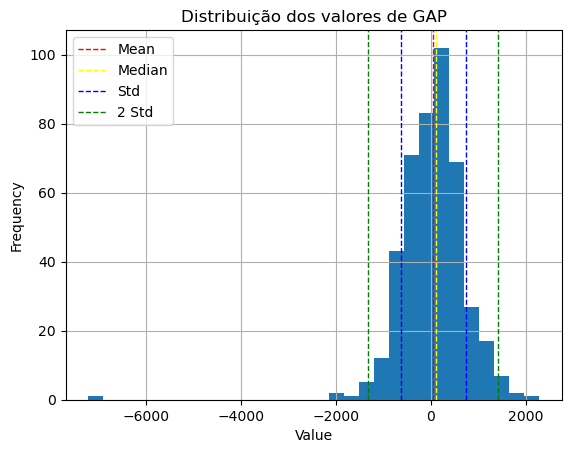

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean, median, and standard deviation
mean = np.mean(df_gap_0900['GAP'])
median = np.median(df_gap_0900['GAP'])
std = np.std(df_gap_0900['GAP'])

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribuição dos valores de GAP")

# Plotting hist
df_gap_0900['GAP'].hist(bins=30)

# Add the mean, median, and standard deviation lines to the plot
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(median, color='yellow', linestyle='dashed', linewidth=1, label="Median")
plt.axvline(mean + std, color='blue', linestyle='dashed', linewidth=1, label="Std")
plt.axvline(mean - std, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean + 2 * std, color='green', linestyle='dashed', linewidth=1, label="2 Std")
plt.axvline(mean - 2 * std, color='green', linestyle='dashed', linewidth=1)

# Add the legend
plt.legend()

# Display the plot
plt.show()

##### Removendo outliers para nova análise

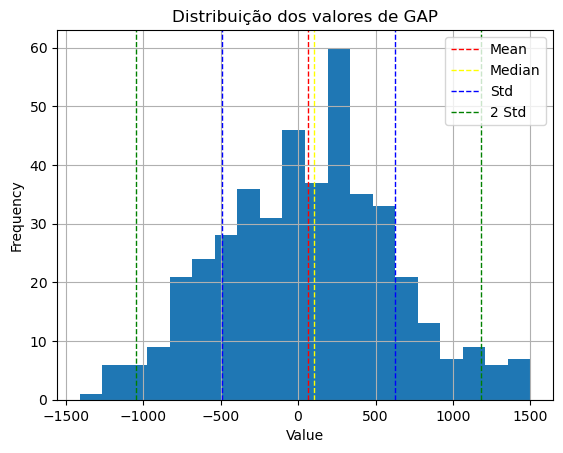

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Remove outliers
q1 = df_gap_0900['GAP'].quantile(0.25)
q3 = df_gap_0900['GAP'].quantile(0.75)
iqr = q3 - q1
outlier_selection = (df_gap_0900['GAP'] >= q1 - 1.5 * iqr) & (df_gap_0900['GAP'] <= q3 + 1.5 * iqr)
df_gap_remove_outliers = df_gap_0900[outlier_selection]

# Calculate the mean, median, and standard deviation
mean_remove_outliers = np.mean(df_gap_remove_outliers['GAP'])
median_remove_outliers = np.median(df_gap_remove_outliers['GAP'])
std_remove_outliers = np.std(df_gap_remove_outliers['GAP'])

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribuição dos valores de GAP")

# Plotting hist
df_gap_remove_outliers['GAP'].hist(bins=20)

# Add the mean, median, and standard deviation lines to the plot
plt.axvline(mean_remove_outliers, color='red', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(median_remove_outliers, color='yellow', linestyle='dashed', linewidth=1, label="Median")
plt.axvline(mean_remove_outliers + std_remove_outliers, color='blue', linestyle='dashed', linewidth=1, label="Std")
plt.axvline(mean_remove_outliers - std_remove_outliers, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_remove_outliers + 2 * std_remove_outliers, color='green', linestyle='dashed', linewidth=1, label="2 Std")
plt.axvline(mean_remove_outliers - 2 * std_remove_outliers, color='green', linestyle='dashed', linewidth=1)

# Add the legend
plt.legend()

# Display the plot
plt.show()

#### Visualizando aumento médio e frequência de aumento em relação ao momento de abertura

In [11]:
def bar_plot(series, title, xlabel, ylabel):
    # Plotting bar
    ax = series.plot.bar()

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Settings
    xlabels = [f'09:{str(x).zfill(2)}:00' for x in range(20)]
    ax.set_xticklabels(xlabels, rotation=-45)
    ax.set_xticks(ax.get_xticks()[::2])
    plt.grid(True)

    # Display the plot
    plt.show()
    
def plot_query(query='', titulo_aumento='Aumento médio em relação à abertura'):
    # Obtendo dados que atendem aos requerimentos
    
    if not query:
        indexes = df_gap_0900.index
    else:
        indexes = df_gap_0900.query(query).index
    print(f'{len(indexes)} de {len(df_gap_0900)} registros atendem a esses requerimentos')
    
    # Organizando dados para serem plotados
    df = return_20_next(indexes)
    df_aumento = df.sub(df[0], axis=0)
    bar_plot(df_aumento.mean(), titulo_aumento, 'Tempo', 'Aumento médio')
    
    tag = np.where(df_aumento > 0, 1, 0)
    df_tag = pd.DataFrame(data=tag)
    df_tag.index = df_aumento.index
    relative_frequency = df_tag.sum() / df_tag.shape[0]
    bar_plot(relative_frequency, 'Frequência relativa de aumento', 'Tempo', 'Frequência')

##### Desconsiderando gap

443 de 443 registros atendem a esses requerimentos


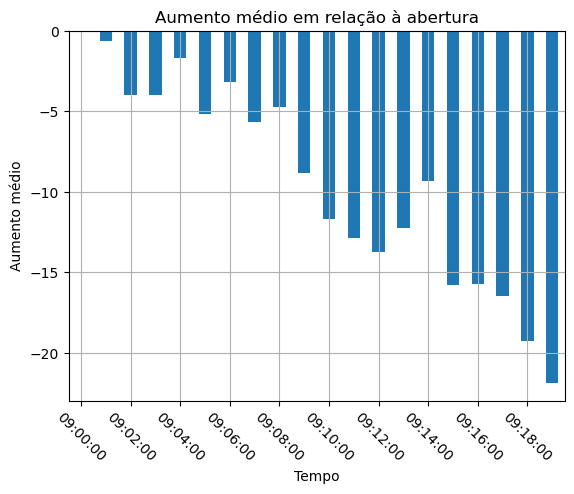

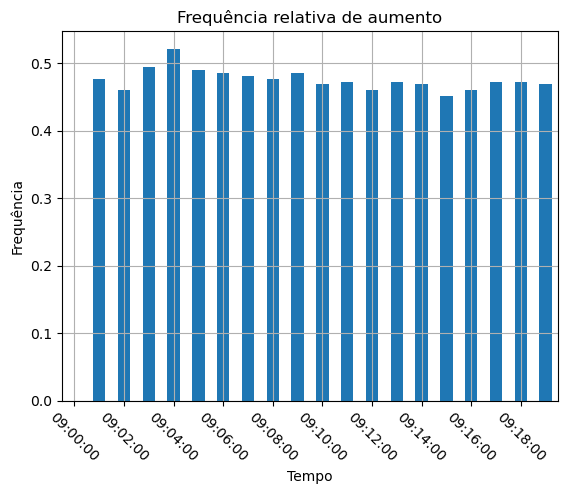

In [12]:
plot_query()

##### Considerando gap

In [13]:
x = std_remove_outliers

###### Gap > x ou Gap < -x

142 de 443 registros atendem a esses requerimentos


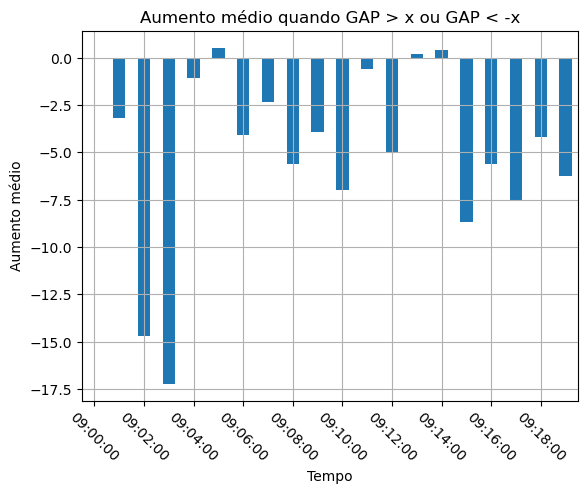

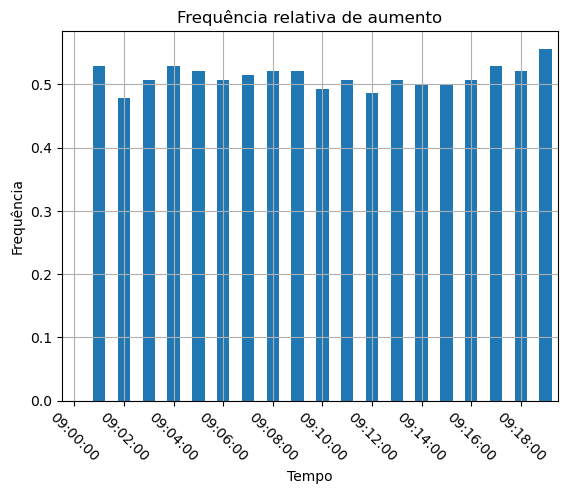

In [14]:
plot_query('GAP > @x or GAP < - @x', 'Aumento médio quando GAP > x ou GAP < -x')

###### GAP > x

76 de 443 registros atendem a esses requerimentos


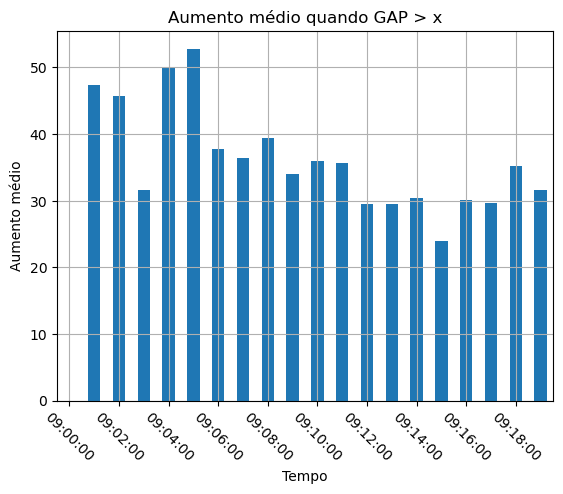

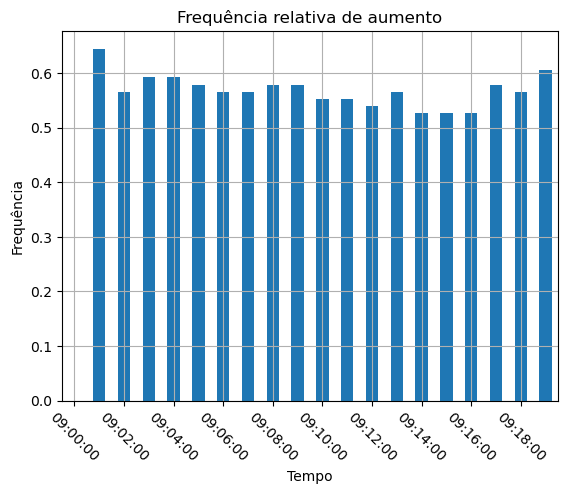

In [15]:
plot_query('GAP > @x', 'Aumento médio quando GAP > x')

###### GAP < -x

66 de 443 registros atendem a esses requerimentos


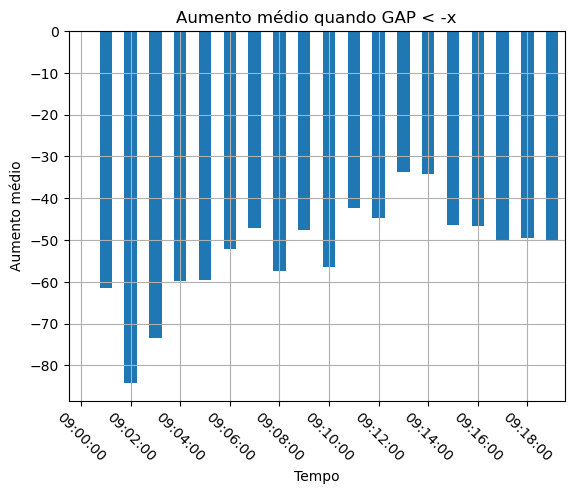

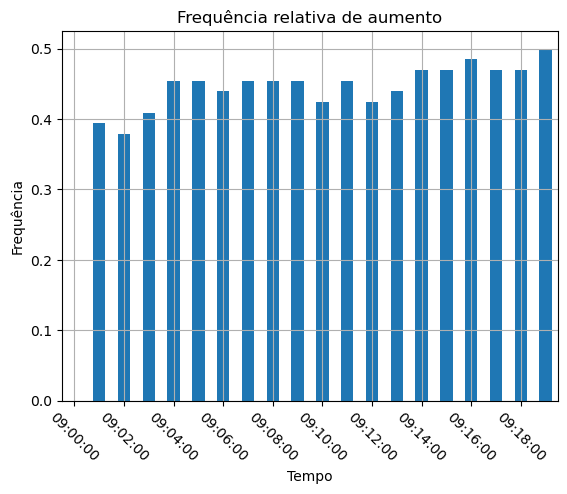

In [16]:
plot_query('GAP < -@x', 'Aumento médio quando GAP < -x')

###### 0 < GAP < x

168 de 443 registros atendem a esses requerimentos


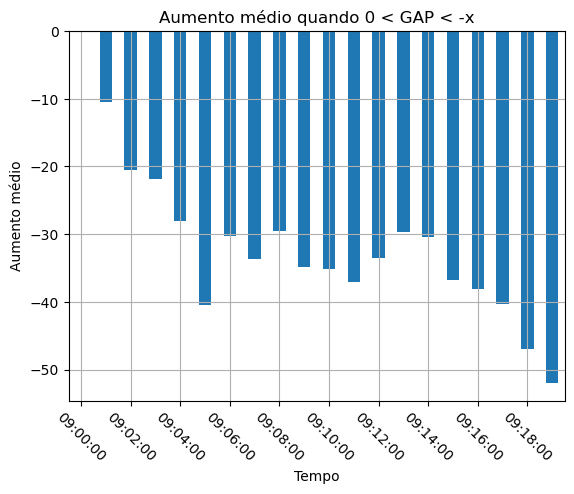

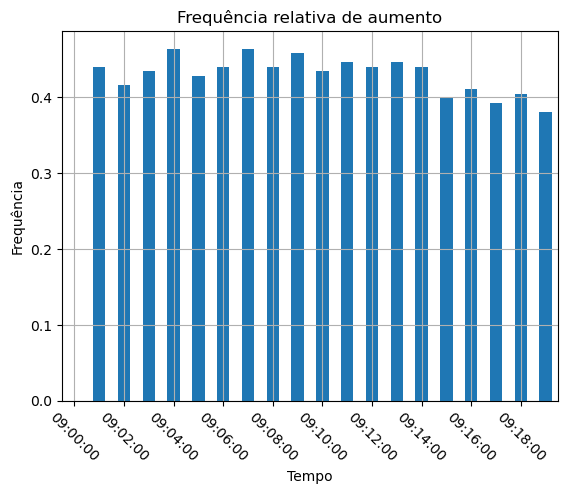

In [17]:
plot_query('GAP < @x and GAP > 0', 'Aumento médio quando 0 < GAP < -x')

###### -x < GAP < 0

149 de 443 registros atendem a esses requerimentos


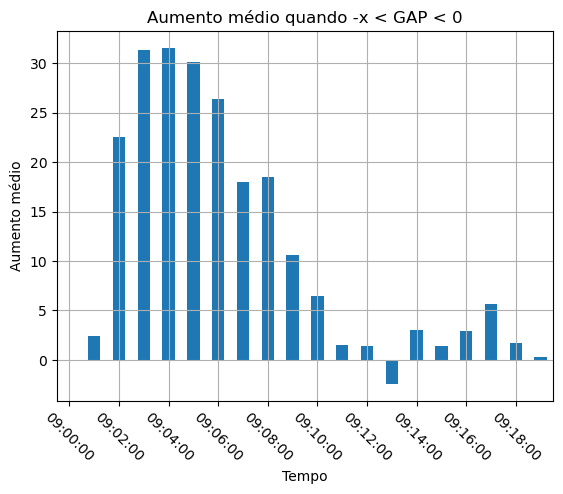

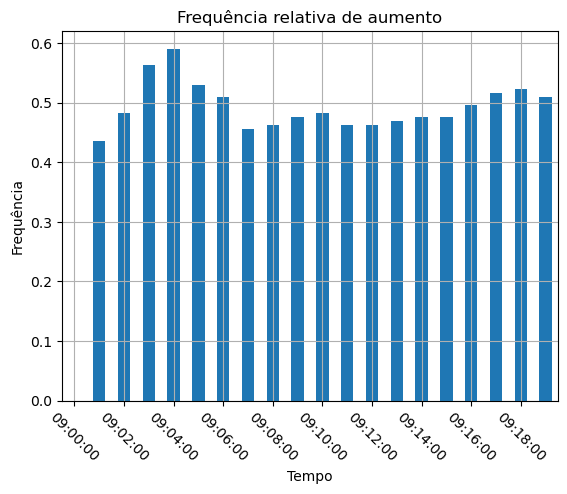

In [18]:
plot_query('GAP > -@std and GAP < 0', 'Aumento médio quando -x < GAP < 0')

# Proposta de modelo

## - std < GAP < 0 ou GAP > std

204 de 443 registros atendem a esses requerimentos


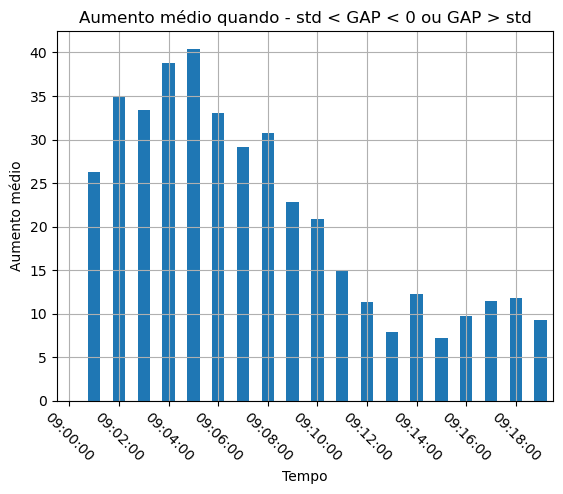

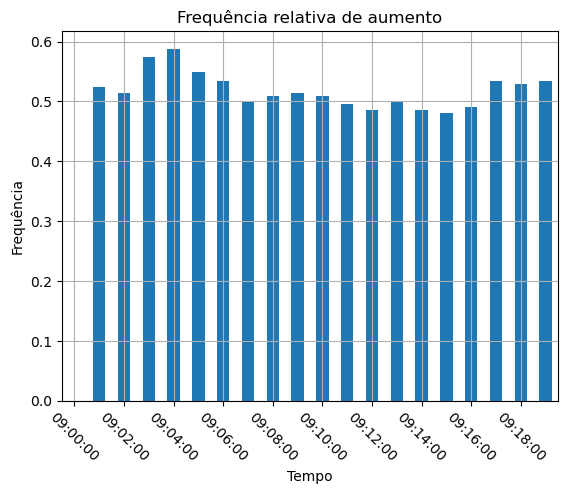

In [19]:
plot_query('(GAP > -@x and GAP < 0) or (GAP > @x)', 'Aumento médio quando - std < GAP < 0 ou GAP > std')

## GAP < -std ou 0 < GAP < std

234 de 443 registros atendem a esses requerimentos


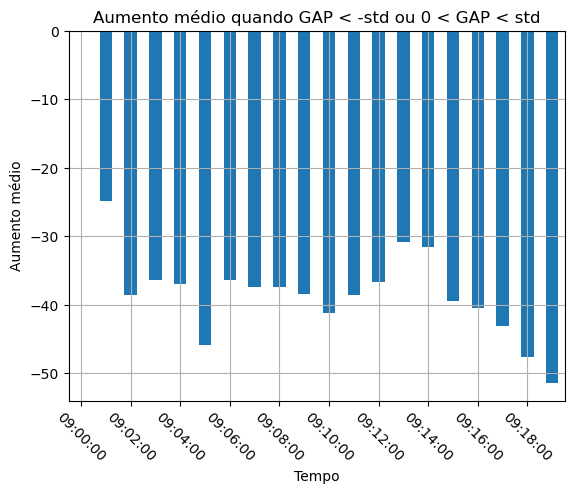

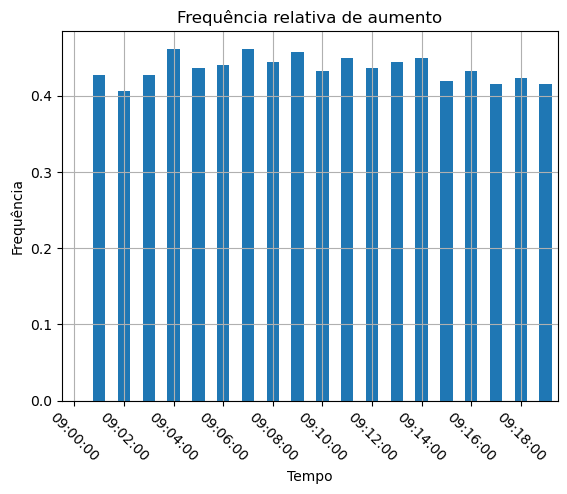

In [20]:
plot_query('(GAP < - @x) or (GAP < @x and GAP > 0)', 'Aumento médio quando GAP < -std ou 0 < GAP < std')